#### ArtSee Demo
In this notebook, you can run the initial version of ArtSee algorithms. If you have taken a picture of any famous artwork (paintings only for now), you can upload the photo to detect what artworks are in the picture. Currently, two search methods are available, the quick search and the exhaustive search. 

The quick search is generally enough, and the exhaustive search should only be used if the picture is in the following conditions:
* The obstacles are blocking more than 50% of the artwork.
* The artwork, mainly paintings, is taken from a very sharp angle (taking it too much from the side).
* The picture quality is quite low.

The quick search does the following;

1. Takes the photo as the input
2. Use Object Detection to detect all the available artworks (paintings only for now), resulting in bounding boxes for each artwork.
3. Crops the artwork out of the overall picture based on the bounding boxes.
4. Preprocess the cropped image
5. Obtains the vector (embedding) of the cropped image with Resnet
6. Does a vector similarity search with the received vector
7. Returns the closest vector to our received vector.
8. The returned vector must be the vector of the artwork we were looking for.
9. Thus, return the artwork.

The exhaustive search does the same exact thing as the fast search with a few additional steps:

Between steps 4 & 5 -> 
* In case of photos taken from a very sharp angle, do Image Segmentation and take all the points of the segmentation.
* Calculate the Convex Hull and do a quadrangle fit ( retrieve a plane with four corners only ).
* Since then primary assumption is that the painting is skewed to some degree, calculate the degree and fit the image into a square. 
* Continue...

If the problem persists due to a large scale of obstacles;

* Do Semantic Segmentation to detect the obstacles and turn all the pixels remaining in the area seen by the segmentation model to black.
* Try to fill in the black area with Inception algorithms
* Continue

BEWARE THAT THE ARTWORK YOU ARE LOOKING FOR MUST BE ALREADY AVAILABLE IN (A HIGH-QUALITY-RESOLUTION PICTURE) IN THE DATABASE, AND THE VECTOR (EMBEDDING) MUST BE ALREADY COMPUTED.


In [1]:
import numpy as np
import pandas as pd
import time
import os
import math
from tqdm import tqdm
from PIL import Image as PILImage

from IPython.display import display
from ultralytics import YOLO

import faiss

#Torch libs
import torch
import torchvision.models as models
import torchvision.transforms as transforms

#Visuals
import plotly.express as px
from plotly import subplots

import requests
from io import BytesIO



df_paintings = pd.read_excel("data-base\data-base.xlsx")
df_paintings = df_paintings.drop("Unnamed: 0", axis = 1)

#model_det = torch.hub.load("ultralytics/yolov5", "custom", path = "D:\Github\ObjectDetection\object-detection\models\Model Details\\v8-boundingbox-perceise\weights\\best.pt", force_reload = True)
model_det = YOLO("models\Model Details\\v8s-detect-epochs400-imgsz800\\weights\\best.pt")
#model_seg = YOLO("models/Model Details/16-300-ImageSegf/weights/best.pt")
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

# Load the pre-trained ResNet-152 model
resnet152 = models.resnet152(pretrained=True)

    # Remove the last layer (classification) to use the model as a feature extractor
resnet152 = torch.nn.Sequential(*(list(resnet152.children())[:-1]))

    # Set the model to evaluation mode
resnet152.eval()

# Define the preprocessing pipeline for the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




def image_to_embedding(image_np: np.ndarray, verbose = 1):
    """
    Takes an image and returns the embedding of the given image.

    Args:
        image_np (np.ndarray): Image as in numPy array
        verbose (boolean): To print progress statements or not

    Returns:
        embedding_np (list -> float): Returns a list with embedding values where len(embedding) = 2048 due to ResNet

    """
    if verbose:
        print("Embedding -> create")
    start = time.process_time()
    # Convert the NumPy array to a PIL image
    image_pil = PILImage.fromarray(image_np)
    if verbose:
        print("---- numpy to PIL:", time.process_time() - start)

    # Preprocess the input image
    image_tensor = preprocess(image_pil)
    if verbose:
        print("---- preprocess:", time.process_time() - start)

    # Add a batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    if verbose:
        print("---- add a batch dimension:", time.process_time() - start)

    # Forward pass the input image through the model
    with torch.no_grad():
        embedding = resnet152(image_tensor)
    if verbose:
        print("---- get the embedding:", time.process_time() - start)

    # Remove the spatial dimensions and convert the tensor to a NumPy array
    embedding_np = embedding.squeeze().numpy()
    if verbose:
        print("---- convert to numpy:", time.process_time() - start)

    return embedding_np





def crop_detections(results, img):
    """
    Takes the input image with the corresponding bounding box coordinates, 
    and returns the sub-images based on the given bounding box coordinates

    Args: 
        results (results[0].boxes where results = YOLO(img) ): Boxes results of YOLO v8 predictions

    Returns:
        images (list): A 2D list where each element is a cropped image (np.ndarray)
    
    """

    extra_space = 0
    
    # For Robustness; Tensor becomes Numpy array
    if torch.is_tensor(results):
        print("Converting Tensor to Numpy")
        results = results.cuda()
        results = results.cpu()
        results = results.to('cpu')
        results = results.numpy()

    images = []

    # Each corrs element -> consisting 4 points, for each corner of the rectangle. Thus, results.xyxy should contain n*[x1, y1, x2, y2]
    for corrs in results.xyxy:
        # Crop it here
        tmp = img[int(corrs[1])-extra_space:int(corrs[3]+extra_space), int(corrs[0]-extra_space):int(corrs[2]+extra_space)]
        # Add it to the list
        images.append(tmp)

    return images


def download_image(url: str) -> np.array:
    """
    At the given URL, download the image and return it as an np.array
    
    """


    response = requests.get(url)
    img = PILImage.open(BytesIO(response.content))
    img = np.array(img)
    return img

    


def visualize_crops(image):
    
    # columns x rows
    columns = 4
    rows = math.ceil(len(image)/4)

    fig = subplots.make_subplots(rows=rows, cols=columns)
    count = 0
    for i in range(4):
        for j in range(rows):

            # Add the image to the trace
            fig.add_trace(px.imshow(image[count]).data[0], row=j+1, col=i+1)

            count += 1
            if count == len(image):
                return fig, rows



Using cache found in C:\Users\Tutu/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Launch the database

In [5]:
create_embeddings = False
embeddings_array = []
directory_names = []
directory = 'data-base\\artworks'
 
# iterate over files
print("Convert everything to JPG...")
for filename in tqdm(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):

        tmp = filename.split(".")
        if tmp[1] != "jpg":
            img_png = PILImage.open(directory + "\\"  + filename)

            rgb_img = img_png.convert('RGB')

            #The image object is used to save the image in jpg format
            rgb_img.save(directory + "\\"  + tmp[0] + ".jpg")

# IF AN ERROR OCCURED, DELETE ALL THE PNG IMAGES IN THE FOLDER AND RUN THIS CELL AGAIN
img_dir_array = []
if create_embeddings:
    
    print("Create Embeddings...")

    for filename in tqdm(os.listdir(directory)):

        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):

            img_dir = directory + "\\"  + filename

            img_dir_array.append(filename)

            information = filename.split("-")
            index_info = int(information[0])
            
            """
            name = ""

            for i in range(len(information)):
                if i == 0 :
                    index_info = int(information[i])
                else:
                    name += information[i]
                    name += " "

            name = name[:-5]

            """
                      
            directory_names.append(img_dir)
            query_embedding = image_to_embedding(np.array(PILImage.open(img_dir)), verbose = 0)

            query_embedding = query_embedding.tolist()

            query_embedding.insert(0, int(index_info))
            #query_embedding.insert(1, name)
            embeddings_array.append(query_embedding)

    df_embeddings_index = pd.DataFrame(embeddings_array)
    df_embeddings_index = df_embeddings_index.rename({0: 'painting-index'}, axis=1) #, 1: 'painting-name-orig'}, axis=1)
    df_embeddings_index = df_embeddings_index.sort_values(by="painting-index")

    #df_embeddings_index.to_csv("data-base\embeddings.csv")

else:
    
    df_embeddings_index = pd.read_csv("data-base\embeddings.csv").drop("Unnamed: 0", axis = 1)


#pd.merge(df_paintings, df_embeddings, on = "painting-index")
df_embeddings = df_embeddings_index.drop(["painting-index"], axis = 1)
embeddings_array = df_embeddings.values

Convert everything to JPG...


100%|██████████| 83/83 [00:00<00:00, 10372.97it/s]


In [6]:
def add_new_data(artist: str, year: int, painting_name_en: str, painting_name_orig: str, dir: str):


    info = dir.split("-")
    
    row = {
              'painting-index': int(info[0]),
              'artist': artist,
              'year': year,
              'painting-name-en': painting_name_en,
              'painting-name-orig': painting_name_orig,
              'dir': dir
           }
    
    
    query_embedding = image_to_embedding(np.array(PILImage.open("data-base\\artworks\\" + dir)), verbose = 0).tolist()
    query_embedding.insert(0, int(info[0]))



    df_embeddings_index.loc[len(df_embeddings.index)] = query_embedding
    df_paintings.loc[len(df_paintings.index)] = row


    #df_paintings = df_paintings.append(row, ignore_index = True)
    #df_paintings.to_excel("data-base\data-base.xlsx")

def save_dbs():

    #df_embeddings_index = df_embeddings_index.sort_values(by="painting-index")
    #df_paintings = df_paintings.sort_values(by="painting-index")
    df_embeddings_index.to_csv("data-base\embeddings.csv")
    
    df_paintings.to_excel("data-base\data-base.xlsx")

#CONTROL PANEL: Not advised to touch
locked = True
if not locked:
    add_new_data(artist = "Vincent Van Gogh",
             year = 1890,
             painting_name_en = "Vase with Daisies and Poppies",
             painting_name_orig = "Vase with Daisies and Poppies",
             dir = "83-vase-with-daisies-and-poppies.jpg"
             )

save_dbs()


In [7]:
# Mandatory Step: Run this cell

# Normalize
normalize = 0
if normalize:
    print("Embeddings Normalized...")
    embeddings_array  = embeddings_array  / np.linalg.norm(embeddings_array , axis=1)[:, np.newaxis]
    index = faiss.IndexFlatIP(2048)
    #index = faiss.IndexFlatL2(2048)
    

else:
    embeddings_db = np.array(embeddings_array )
    index = faiss.IndexFlatL2(2048) # EN IYI BU CALISIYO


index.add(embeddings_array)
print("Vector Search Index: OK!")

Vector Search Index: OK!


Downloading...
Assesing...



0: 544x800 1 Tablo, 379.9ms
Speed: 8.1ms preprocess, 379.9ms inference, 9.0ms postprocess per image at shape (1, 3, 800, 800)


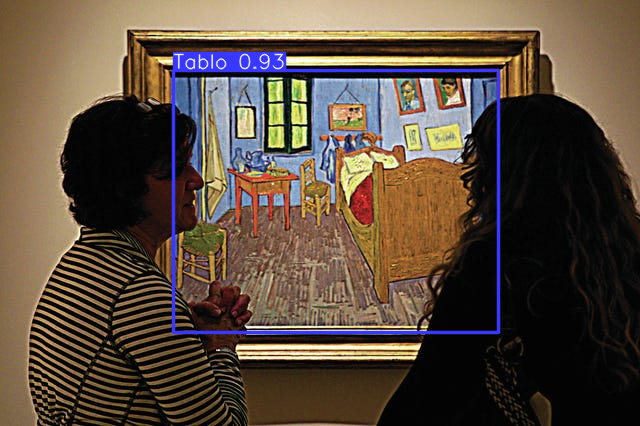

In [9]:
#Step 1: Download the image and find paintings

#Download the image from the link
print("Downloading...")


url = "https://www.gannett-cdn.com/authoring/2013/10/13/NBEE/ghows-OK-79618799-bbd7-4557-904f-01ce295c9677-66f0ea9b.jpeg?width=1200&disable=upscale&format=pjpg&auto=webp"

img = download_image(url = url)

# When cropping the image, the save of the original image is used
img_visualized = img.copy()

# Scale down the image which will be printed
scale_size = 1
height, width = img_dimensions = img_visualized.shape[:2]
height, width = int(height/scale_size), int(width/scale_size)

# Run the YOLO algorithm
print("Assesing...")
results = model_det(img_visualized)


# Save the results
display(PILImage.fromarray(results[0].plot(line_width = 2)).resize((width, height)))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: [%{z[0]}, %{z[1]}, %{z[2]}]<extra></extra>',
              'name': '0',
              'source': ('data:image/png;base64,iVBORw0K' ... 'H5+t9iUe3YkAAAAABJRU5ErkJggg=='),
              'type': 'image',
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'autosize': False,
               'height': 400,
               'margin': {'b': 100, 'l': 0, 'r': 0, 't': 0},
               'template': '...',
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.2125]},
               'xaxis2': {'anchor': 'y2', 'domain': [0.2625, 0.475]},
               'xaxis3': {'anchor': 'y3', 'domain': [0.525, 0.7375]},
               'xaxis4': {'anchor': 'y4', 'domain': [0.7875, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 1.0]},
               'yaxis3': {'anchor': 'x3', 'domain': [0.0, 1.0]},
               'yaxis4': {'anchor': 'x4', 'domain': [0.0, 1.0]}}
})
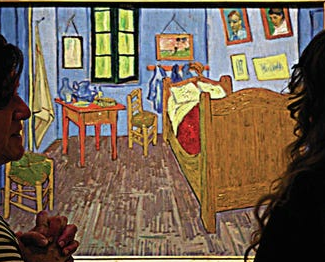

In [10]:
# For individual croppings, run this cell

images = crop_detections(results[0].boxes, img)
fig, rows = visualize_crops(images)
fig.update_layout(
    autosize=False,
    width=1000,
    height=rows*400,
    margin=dict(l=0, r=0, t=0, b=100))

In [14]:
# In one shot
image_index = 0
start = time.process_time()

model_det.conf = 0.9

# Get the absolute path of the current script
script_dir = os.path.dirname(os.path.abspath("artsee-demo.ipynb"))

# If the previous 2 cells not runned yet, run the following lines

#url = "https://gemaeldegalerie.skd.museum/fileadmin/_processed_/b/2/csm_090921killig049_45ba439801.jpg"
#img = download_image(url = url)

img_visualized = img.copy()
print("Download Image:", time.process_time() - start)


results = model_det(img_visualized)
print("Results Obtained:", time.process_time() - start)

images = crop_detections(results[0].boxes, img)
print("Cropped:", time.process_time() - start)

input_embedding = image_to_embedding(images[image_index])
print("Embedding Obtained:", time.process_time() - start)



input_embedding = np.array([input_embedding / np.linalg.norm(input_embedding)]) if normalize else np.array([input_embedding])



print("Embedding Normalized:", time.process_time() - start)

distances, indices = index.search(input_embedding, 25)
print("Searched:", time.process_time() - start, "\n")


for i in range(3):
    information = df_paintings.iloc[indices[0][i]].values.flatten().tolist()

    path = script_dir + "\\data-base\\artworks\\" + information[-1]
    print(information[:-1], path)

distances


    

Download Image: 0.0


0: 544x800 1 Tablo, 399.9ms
Speed: 6.0ms preprocess, 399.9ms inference, 2.0ms postprocess per image at shape (1, 3, 800, 800)


Results Obtained: 2.453125
Cropped: 2.453125
Embedding -> create
---- numpy to PIL: 0.09375
---- preprocess: 0.09375
---- add a batch dimension: 0.09375
---- get the embedding: 2.234375
---- convert to numpy: 2.234375
Embedding Obtained: 4.6875
Embedding Normalized: 4.6875
Searched: 4.6875 

[76, 'Vincent Van Gogh', 1888, 'The Bedroom At Arles', 'Slaapkamer te Arles'] c:\Users\Tutu\Desktop\ArtSee-App\Demo\data-base\artworks\76-the-bedroom-at-arles.jpg
[5, 'Osman Hamdi Bey', 1880, 'Gebze Shepherd Mustafa Pasha Complex', "Gebze'de Çoban Mustafa Paşa Külliyesi"] c:\Users\Tutu\Desktop\ArtSee-App\Demo\data-base\artworks\5-gebzede_coban_mustafa_pasa_kulliyesi.jpg
[73, 'Vincent Van Gogh', 1888, 'The Yellow House', 'Het gele huis'] c:\Users\Tutu\Desktop\ArtSee-App\Demo\data-base\artworks\73-the-yellow-house.jpg


array([[     251.36,      387.28,      431.27,      432.57,      449.01,      449.38,      450.17,      456.99,      463.51,      464.48,      468.59,      469.45,      474.17,      474.38,      476.03,      480.39,      487.73,      488.01,      495.59,       497.2,      498.71,      512.95,      514.83,
             521.21,      527.49]], dtype=float32)

In [17]:
script_dir

'c:\\Users\\Tutu\\Desktop\\ArtSee App\\Demo'

In [16]:
script_dir.split(" ")

['c:\\Users\\Tutu\\Desktop\\ArtSee', 'App\\Demo']